In [1]:
import numpy as np
import time
import math
import scipy
from scipy import signal, optimize
from scipy.sparse.linalg import LinearOperator
import h5py
import sys, os, psutil
from datetime import datetime

from devito import Grid, Eq, solve, TimeFunction, Operator, gaussian_smooth, Function
from distributed import Client, LocalCluster, wait
import cloudpickle as pickle

# Import acoustic solver, source and receiver modules.
from examples.seismic import Model, demo_model, AcquisitionGeometry, Receiver, TimeAxis, RickerSource, GaborSource
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import AcquisitionGeometry

from devito import configuration
configuration['log-level'] = 'WARNING'

from devito.logger import error, warning

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

param = {'t0': 0.,
         'tn': 5000.,              # Simulation last 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 1,              # Number of shots to create gradient from
         'shape': (921, 319),      # Number of grid points (nx, nz).which is only defined in 2layer model, as marmousi model has a fixed shape
         'spacing': (10., 10.),    # Grid spacing in m. The domain size is now 1km by 1km.
         'origin': (0, 0),         # Need origin to define relative source and receiver locations.
         'nbl': 1000,
         'vp_top': 2,
         'space_order':4,
         'bcs':'damp',
         'dtype':np.float64,
         'dt': 0.8,
        'nreceivers':231,
         'type_of_shots':'central',
         'npad_in':40,
         'shot_depth':20,
         'receiver_depth':20,
         'niter':30,
        'model_type':'marmousi',#marmousi or bp2004
        'location_of_this_code':'ymsc',#tianhe or ymsc
         'source_type':'Ricker', #only ricker can be used
         'use_critical_dt':False,
         'source_location_central':True, #True or False, used for testing 
         'number_worker':12,
         'number_per_step':12,#must be smaller than number of workers
         'filter_sigma':(3,3)
        }     

def L2loss(noisy,gt):
    res = noisy - gt
    msegt = np.mean(gt * gt)
    mseres = np.mean(res * res)
    loss = mseres/msegt
    return loss

def get_print():
    print(u'The memory used at present: %.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    print(('The time at present is {}'.format(datetime.now())))

def param_reset():
    if(param['model_type'] == 'marmousi'):
        param['shape'] = (921,319)
        param['origin'] = (0,0)
        param['spacing'] = (10,10)
    if(param['model_type'] == 'bp2004'):
        param['shape'] = (1000,319)
        param['origin'] = (0,0)
        param['spacing'] = (10,10)
    
def get_true_model_velocity():
    '''
    model type = marmousi
    '''
    if(param['model_type'] == 'marmousi'):
        if (param['location_of_this_code'] == 'tianhe'):
            dat = np.load("/fs2/home/ymsc_cpu/homes/wangrongqian/lsrtm/model/sigsbee_scale_true.npy",allow_pickle=1)
        elif(param['location_of_this_code'] == 'ymsc'):
            dat = np.load('/home1/wangrongqian2022/smi_new/vel_Marmousi_true.npy',allow_pickle=1)
        else: error('The location of this code, param[location_of_this_code], must be tianhe or ymsc')
        datalist = dat.tolist()
        v_marmousi_true = datalist['vp']/1000

        return v_marmousi_true
    
    if(param['model_type'] == 'bp2004'):
        if (param['location_of_this_code'] == 'tianhe'):
            dat = np.load("/fs2/home/ymsc_cpu/homes/wangrongqian/lsrtm/model/sigsbee_scale_true.npy",allow_pickle=1)
        elif(param['location_of_this_code'] == 'ymsc'):
            dat = np.load('/home1/wangrongqian/source_transformation/BP2004_1000*319_true.npy',allow_pickle=1)
        else: error('The location of this code, param[location_of_this_code], must be tianhe or ymsc')
            
        datalist = dat.tolist()
        vbp2004_true = datalist['vp']/1000

        return vbp2004_true
        
def get_true_model():
    ''' Define the test phantom; in this case we are using
    a simple circle so we can easily see what is going on.
    '''
    if (param['use_critical_dt']):
        return Model(vp=get_true_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'])
    else:
        critical_dt_model = Model(vp=get_true_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype']).critical_dt
        print('Critical dt of model is',critical_dt_model,'s, the dt defined here is',param['dt'])
        if (param['dt'] > 1e-4 + critical_dt_model):
            error('The dt setted here is larger than the critical dt of this model')

        return Model(vp=get_true_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'],dt = param['dt'])
        
def get_initial_model():
    if (param['use_critical_dt']):
        model0 = Model(vp=get_true_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                  space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'],dt = get_true_model().critical_dt)
    else:
        model0 = Model(vp=get_true_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                  space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'],dt = param['dt'])
    gaussian_smooth(model0.vp, sigma=param['filter_sigma'])
    return model0
    
def get_water_model_velocity():
    '''
    model type = marmousi
    '''

    if(param['model_type'] == 'marmousi'):
        dat = np.load('/home1/wangrongqian2022/smi_new/vel_Marmousi_true.npy',allow_pickle=1)
    elif(param['model_type'] == 'bp2004'):
        dat = np.load('/home1/wangrongqian/source_transformation/BP2004_1000*319_true.npy',allow_pickle=1)
    else: error('The location of this code, param[location_of_this_code], must be tianhe or ymsc')
    datalist = dat.tolist()
    v_marmousi_true = datalist['vp']/1000
    v_water_true = v_marmousi_true.copy()
    v_water_true[:,:] = v_marmousi_true[0,0]
    return v_water_true
        
def get_water_model():
    ''' Define the test phantom; in this case we are using
    a simple circle so we can easily see what is going on.
    '''
    if (param['use_critical_dt']):
        return Model(vp=get_water_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'])
    else:
        critical_dt_model = Model(vp=get_water_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype']).critical_dt
        print('Critical dt of model is',critical_dt_model,'s, the dt defined here is',param['dt'])
        if (param['dt'] > 1e-4 + critical_dt_model):
            error('The dt setted here is larger than the critical dt of this model')

        return Model(vp=get_water_model_velocity(), origin=param['origin'], shape=get_true_model_velocity().shape, spacing=param['spacing'],
                      space_order=param['space_order'],bcs=param['bcs'],nbl=param['nbl'],dtype=param['dtype'],dt = param['dt'])

def get_ntime():
    time_range = TimeAxis(start=param['t0'], stop=param['tn'], step=param['dt'])
    return time_range.num

def get_geometry():
    # Generate shot data.
    src_coordinates = np.empty((1, len(param['shape'])))# = (1,2)
    src_coordinates[:, 0] = np.linspace(param['npad_in'], model.domain_size[0]-param['npad_in'], num=1)#temptemp
    src_coordinates[:, 1] = param['shot_depth']
    
    nreceivers = param['nreceivers']
    rec_coordinates = np.empty((param['nreceivers'], len(param['shape'])))# = (nreceivers, 2)
    rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
    rec_coordinates[:, 1] = param['receiver_depth']  # 20m from the right end
    # Geometry 
    return AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                                   param['t0'], param['tn'], src_type=param['source_type'],
                                   f0=param['f0'])

def get_source_locations():
    source_locations = np.empty((param['nshots'], 2), dtype=param['dtype'])
    if (param['source_location_central']):
        source_locations[:, 0] = np.array(get_true_model().domain_size[0]) * .5
    else:
        source_locations[:, 0] = np.linspace(param['npad_in'], 
                                            get_true_model().domain_size[0]-param['npad_in'], num=param['nshots'])
    source_locations[:, 1] = param['shot_depth'] # Depth is 20m
    return source_locations

def load_model(filename):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """
    pkl = pickle.load(open(filename, "rb")) 
    return pkl['model']

def dump_model(filename, model):
    ''' Dump model to disk.
    '''
    pickle.dump({'model':model}, open(filename, "wb"))

def load_shot_data(shot_id):
    ''' Load shot data from disk, resampling to the model time step.
    '''
    pkl = pickle.load(open("shot_%d.p"%shot_id, "rb")) 
    return pkl['geometry']

def dump_shot_data(shot_id, geometry):
    ''' Dump shot data to disk.
    '''
    pickle.dump({'geometry': geometry}, open('shot_%d.p'%shot_id, "wb"))
    
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    with open("arguments.pkl", "rb") as cp_file:
        cp = pickle.load(cp_file)    
    solver = cp['solver']

    shot_id=param['shot_id']

    solver.geometry.src_positions[0,:]=get_source_locations()[shot_id, :]
    rec = Receiver(name='rec',grid=solver.geometry.grid,time_range=solver.geometry.time_axis,coordinates=solver.geometry.rec_positions)
    dump_shot_data(shot_id, solver.geometry.src_positions)

def generate_shotdata(solver):
    # Pick devito objects (save on disk)
    cp = {'solver': solver}
    with open("arguments.pkl", "wb") as cp_file:
        pickle.dump(cp, cp_file) 

    work = [dict(param) for i in range(param['nshots'])]
    # synthetic data is generated here twice: serial(loop below) and parallel (via dask map functionality) 
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        generate_shotdata_i(work[i])

    futures = client.map(generate_shotdata_i, work)

    wait(futures)
    
def _pml_absorption(pml_alpha, pml_size, interior_shape, degree, spacing, time_range):
    """
    Refer to the PML used in k-Wave and see details in section 2.6 of the k-Wave manual

    pml_size: int, the thickness of the pml layer
    interior_shape: (Nx,Ny) or (Nx,Ny,Nz)
    """

    pml_mat = np.zeros([i + 2 * pml_size for i in interior_shape])

    if len(interior_shape) == 2:

        # x-direction pml setting
        pml_x = pml_alpha * (
            (np.linspace(spacing[0], pml_size * spacing[0], pml_size)) ** degree
            / (pml_size * spacing[0]) ** degree
        ).reshape(pml_size, 1)
        pml_mat[0:pml_size, :] = np.tile(pml_x[::-1], (1, pml_mat.shape[1]))
        pml_mat[-pml_size:, :] = np.tile(pml_x, (1, pml_mat.shape[1]))

        # y-direction pml setting
        pml_y = pml_alpha * (
            (np.linspace(spacing[1], pml_size * spacing[1], pml_size)) ** degree
            / (pml_size * spacing[1]) ** degree
        )
        pml_mat[:, 0:pml_size] += np.tile(pml_y[::-1], (pml_mat.shape[0], 1))
        pml_mat[:, -pml_size:] += np.tile(pml_y, (pml_mat.shape[0], 1))

        pml_mat = np.exp(pml_mat * time_range.step)
    elif len(interior_shape) == 3:

        # x-direction pml setting
        pml_x = pml_alpha * (
            (np.linspace(spacing[0], pml_size * spacing[0], pml_size)) ** degree
            / (pml_size * spacing[0]) ** degree
        ).reshape(pml_size, 1, 1)
        pml_mat[0:pml_size, :, :] = np.tile(
            pml_x[::-1, :, :], (1, pml_mat.shape[1], pml_mat.shape[2])
        )
        pml_mat[-pml_size:, :, :] = np.tile(
            pml_x, (1, pml_mat.shape[1], pml_mat.shape[2])
        )

        # y-direction pml setting
        pml_y = pml_alpha * (
            (np.linspace(spacing[1], pml_size * spacing[1], pml_size)) ** degree
            / (pml_size * spacing[1]) ** degree
        ).reshape(1, pml_size, 1)
        pml_mat[:, 0:pml_size, :] += np.tile(
            pml_y[:, ::-1, :], (pml_mat.shape[0], 1, pml_mat.shape[2])
        )
        pml_mat[:, -pml_size:, :] += np.tile(
            pml_y, (pml_mat.shape[0], 1, pml_mat.shape[2])
        )

        # z-direction pml setting
        pml_z = pml_alpha * (
            (np.linspace(spacing[2], pml_size * spacing[2], pml_size)) ** degree
            / (pml_size * spacing[2]) ** degree
        ).reshape(1, 1, pml_size)
        pml_mat[:, :, 0:pml_size] += np.tile(
            pml_z[:, :, ::-1], (pml_mat.shape[0], pml_mat.shape[1], 1)
        )
        pml_mat[:, :, -pml_size:] += np.tile(
            pml_z, (pml_mat.shape[0], pml_mat.shape[1], 1)
        )

        pml_mat = np.exp(pml_mat * time_range.step)
        # pml_mat = np.exp(pml_mat)
    else:
        ValueError("Invalid shape of interior_shape.")

    return pml_mat
    
def lsrtm_forward_m_to_d(dm):
    d_syn    = Receiver(name='d_syn',grid=model.grid,time_range=geometry.time_axis,coordinates=geometry.rec_positions)
    dm2 =  dm.astype(param['dtype']).reshape(param['shape'][0]+2*param['nbl'],param['shape'][1]+2*param['nbl'])

    du_full = np.zeros([param['nshots'],ntime,param['nreceivers']])
    for i in range(param['nshots']):
        print('iteration = ',i)
        get_print()
        geometry.src_positions[0, :] = get_source_locations()[i, :]
        solver.jacobian(dm2, vp=get_initial_model().vp, rec = d_syn)
        du_full[i] = d_syn.data
    return np.array(du_full)


def forward_m_to_d(m):
    d_syn    = Receiver(name='d_syn',grid=model.grid,time_range=geometry.time_axis,coordinates=geometry.rec_positions)
    #dm2 =  dm.astype(param['dtype']).reshape(param['shape'][0]+2*param['nbl'],param['shape'][1]+2*param['nbl'])

    du_full = np.zeros([param['nshots'],ntime,param['nreceivers']])
    for i in range(param['nshots']):
        print('iteration = ',i)
        get_print()
        geometry.src_positions[0, :] = get_source_locations()[i, :]
        #d_syn, _, _ = solver.forward(vp=m.vp, dt=param['dt'])
        solver.forward(vp=m.vp, dt=param['dt'], rec = d_syn)
        du_full[i] = d_syn.data
    return np.array(du_full)
'''
def forward_m_to_d(m):
    time_range = TimeAxis(start=param['t0'], stop=param['tn'], step=param['dt'])
    if param['source_type'] == 'Ricker':
        src = RickerSource(name='src', grid=model.grid, f0=param['f0'],
                       npoint=1, time_range=time_range)
    elif param['source_type'] == 'Gabor':
        src = GaborSource(name='src', grid=model.grid, f0=param['f0'],
                       npoint=1, time_range=time_range)

    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 20.  # Depth is 20m

    rec = Receiver(name='rec', grid=model.grid, npoint=param['nreceivers'], time_range=time_range)

    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=param['nreceivers'])
    rec.coordinates.data[:, 1] = 20.  # Depth is 20m

    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)

    pml = Function(name="pml", grid=model.grid)
    # The default value for pml_alpha refers to the manual of k-Wave
    pml.data[:] = _pml_absorption(
        pml_alpha=0.03 * model.vp.data.max() / min(model.spacing),
        # pml_alpha=0.1,
        pml_size=model.nbl,
        interior_shape=model.shape,
        degree=4,  # refer to the choice in k-Wave
        spacing=model.spacing,
        time_range=time_range,
    )
    dt_symbol = model.grid.time_dim.spacing
    pde = (
        (m.m * (pml * u.forward - 2.0 * u + u.backward / pml) / dt_symbol**2)
        - u.laplace
    )
    stencil = Eq(u.forward, solve(pde, u.forward))

    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = src.inject(field=u.forward, expr=src * dt**2 / m.m)

    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u.forward)

    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

    #NBVAL_IGNORE_OUTPUT
    op(time=time_range.num-1, dt=param['dt'])

    pmldata = rec.data.copy()
    return np.array(pmldata)
'''
def plot_data(data):
    cmax = 1
    cmin = -cmax
    colour = 'seismic'
    plt.figure(figsize=(8,9))

    x_major_locator=MultipleLocator(100)
    y_major_locator=MultipleLocator(0.5)
    ax=plt.gca()
    ax.set_xlabel('Distance (km)',fontsize=18)
    ax.set_ylabel('Time (s)',fontsize=18)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    ax.set_xticks([0,50,100,150,200,230]) # 设置刻度
    ax.set_xticklabels(['0.0','2.0','4.0','6.0','8.0','9.2'],rotation = 0,fontsize = 16) # 设置刻度标签
    ax.set_yticks([0,1250,2500,3750,5000,6250]) # 设置刻度
    ax.set_yticklabels(['0.0','1.0','2.0','3.0','4.0','5.0'],rotation = 0,fontsize = 16) # 设置刻度标签

    #ax.set_xlim(0,921)
    #ax.set_ylim(4.5,0)

    plt.imshow(data,cmap=colour,vmax=cmax,vmin=cmin, aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=16)
    #cb.set_ticks([-0.50,-0.25,0.00,0.25,0.50])
    plt.tight_layout()

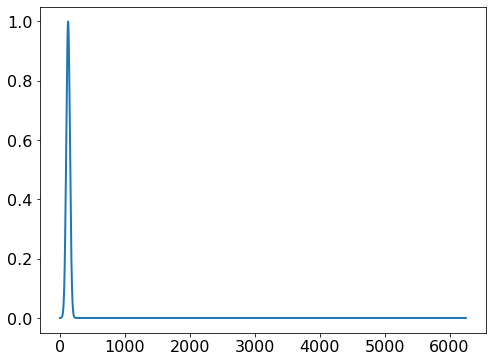

In [2]:
f0 = param['f0']
nt = 6251
dt = param['dt']
x = np.arange(nt)
gaussian = np.zeros(nt)
for t in range(nt):
    r = (np.pi * f0 * (t * dt - 1./f0))
    gaussian[t] = np.exp(-r**2)
#gaussian = gaussian[::3]
plt.plot(x,gaussian,label='Gaussian',linewidth=2)

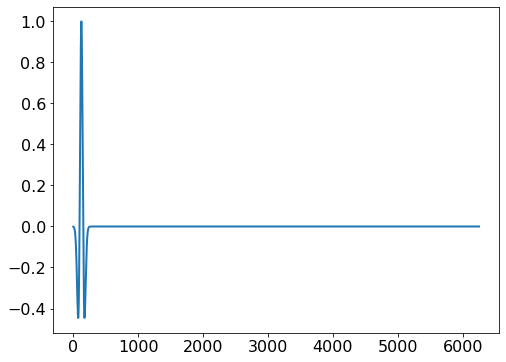

In [3]:
f0 = param['f0']
x = np.arange(nt)
dt = param['dt']
ricker = np.zeros(nt)
for t in range(nt):
    r = (np.pi * f0 * (t * dt - 1./f0))
    ricker[t] = (1-2.*r**2)*np.exp(-r**2)
#gaussian = gaussian[::3]
plt.plot(x,ricker,label='Ricker',linewidth=2)

In [4]:
dt_here = param['dt']#model.critical_dt
ntime = get_ntime()

model = get_true_model()
param['source_type'] = 'Ricker'
geometry = get_geometry()
solver = AcousticWaveSolver(model, geometry, space_order=param['space_order'])
fullwave_ricker = forward_m_to_d(model)

model0 = get_water_model()
param['source_type'] = 'Ricker'
geometry = get_geometry()
solver = AcousticWaveSolver(model, geometry, space_order=param['space_order'])
directwave_ricker = forward_m_to_d(model0)
d_ricker = fullwave_ricker[0] - directwave_ricker[0]

model = get_true_model()
param['source_type'] = 'Gabor'
geometry = get_geometry()
solver = AcousticWaveSolver(model, geometry, space_order=param['space_order'])
fullwave_gaussian = forward_m_to_d(model)

model0 = get_water_model()
param['source_type'] = 'Gabor'
geometry = get_geometry()
solver = AcousticWaveSolver(model, geometry, space_order=param['space_order'])
directwave_gaussian = forward_m_to_d(model0)
d_gaussian = fullwave_gaussian[0] - directwave_gaussian[0]

Critical dt of model is 0.9152 s, the dt defined here is 0.8
iteration =  0
The memory used at present: 0.3892 GB
The time at present is 2023-10-22 18:14:04.756601
Critical dt of model is 0.9152 s, the dt defined here is 0.8
Critical dt of model is 3.46 s, the dt defined here is 0.8
iteration =  0
The memory used at present: 0.6766 GB
The time at present is 2023-10-22 18:16:24.204371
Critical dt of model is 0.9152 s, the dt defined here is 0.8
Critical dt of model is 0.9152 s, the dt defined here is 0.8
iteration =  0
The memory used at present: 0.6383 GB
The time at present is 2023-10-22 18:18:44.069922
Critical dt of model is 0.9152 s, the dt defined here is 0.8
Critical dt of model is 3.46 s, the dt defined here is 0.8
iteration =  0
The memory used at present: 0.8256 GB
The time at present is 2023-10-22 18:21:07.227873
Critical dt of model is 0.9152 s, the dt defined here is 0.8


In [5]:
d_gaussian = fullwave_gaussian[0] - directwave_gaussian[0]
d_ricker = fullwave_ricker[0] - directwave_ricker[0]

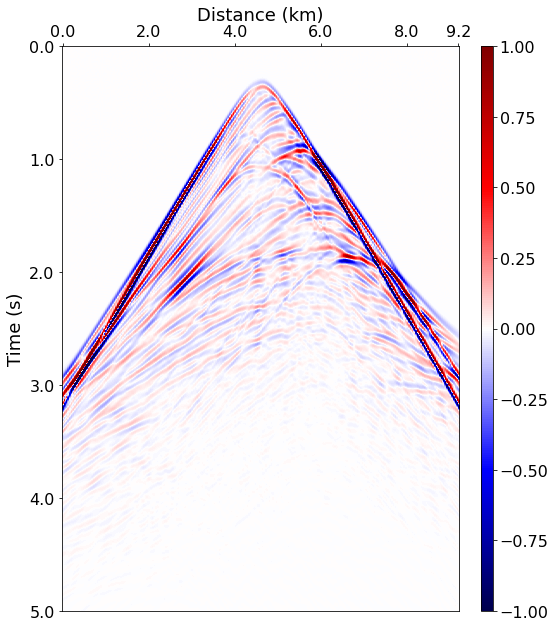

In [6]:
plot_data(d_ricker)

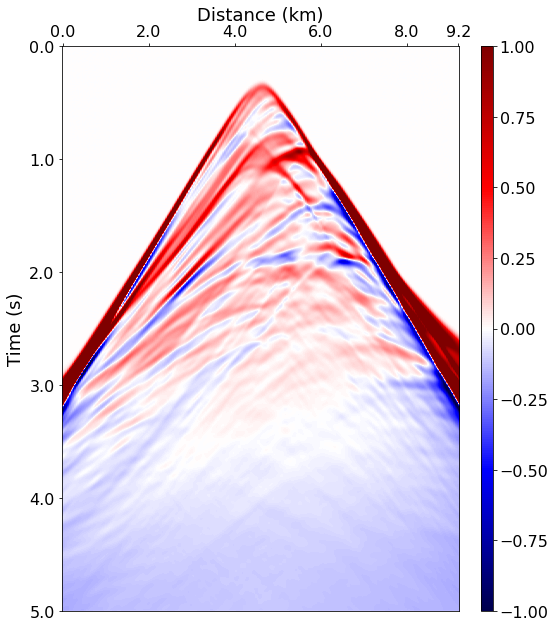

In [7]:
plot_data(d_gaussian)

In [31]:
L1_Gaussian = np.zeros(d_gaussian.shape)
c = 0.02
alpha = 1/c
p = 0.00      # 正则化参数
epsilon = 1e-3  # 最大允许误差
iteration = 10

x_dim = d_gaussian.shape[0]
A = np.zeros((x_dim,x_dim))
for i in range(x_dim):
    for j in range(x_dim):
        if (i-j>-1):
            A[i,j] = ricker[i-j]
A1 = np.linalg.inv(A.T@A + c*np.eye(x_dim, x_dim))

time_span = d_gaussian.shape[0]

ii = 100
l2 = np.zeros(iteration)
u0 = (d_gaussian.T)[ii][:x_dim]
d = (d_ricker.T)[ii][:x_dim]
#u0 = (fullwave_gaussian[0].T)[ii][:x_dim]
#d = (fullwave_ricker[0].T)[ii][:x_dim]
b = np.convolve(gaussian,d,'full')
b = b[:x_dim]
x_k = np.zeros(x_dim)
y_k = np.zeros(x_dim)
v_k = np.zeros(x_dim)
x_k_old = np.zeros(x_dim)
A2 = A.T@b

plot_iteration = []  # 每步计算结果
k = 0  # 迭代次数

while k < iteration:
    # 更新x
    x_k = A1 @ (A2 + c*y_k - v_k)
    x_k[np.abs(u0)<1e-04]=0
    # 更新y（软阈值）
    for i in range(x_dim):
        if x_k[i] + v_k[i]/c < -p/c:
            y_k[i] = x_k[i] + v_k[i]/c + p/c
        elif x_k[i] + v_k[i]/c > p/c:
            y_k[i] = x_k[i] + v_k[i]/c - p/c
        else:
            y_k[i] = 0

    # 更新v
    v_k = v_k + c * (x_k - y_k)

    plot_iteration.append(x_k.copy())  # 记录每步计算结果
    l2[k] = L2loss(x_k,u0)
    x_k_old = x_k.copy()  # 深拷贝
    k += 1

L1_Gaussian[:,ii] = plot_iteration[iteration-1]

In [32]:
L2loss(L1_Gaussian[:,ii],d_gaussian[:,ii])

0.11084799836932173

In [33]:
l2

array([0.32161737, 0.25964801, 0.22269669, 0.19627059, 0.17560791,
       0.1585835 , 0.14410344, 0.13155167, 0.12055072, 0.110848  ])

In [34]:
L1_Gaussian = np.zeros(d_gaussian.shape)
c = 0.02
alpha = 1/c
p = 0.00      # 正则化参数
epsilon = 1e-3  # 最大允许误差
iteration = 10

x_dim = d_gaussian.shape[0]
A = np.zeros((x_dim,x_dim))
for i in range(x_dim):
    for j in range(x_dim):
        if (i-j>-1):
            A[i,j] = ricker[i-j]
A1 = np.linalg.inv(A.T@A + c*np.eye(x_dim, x_dim))

time_span = d_gaussian.shape[0]
for ii in range(d_gaussian.shape[1]):
    l2 = np.zeros(iteration)
    u0 = (d_gaussian.T)[ii][:x_dim]
    d = (d_ricker.T)[ii][:x_dim]
    b = np.convolve(gaussian,d,'full')
    b = b[:x_dim]
    x_k = np.zeros(x_dim)
    y_k = np.zeros(x_dim)
    v_k = np.zeros(x_dim)
    x_k_old = np.zeros(x_dim)
    A2 = A.T@b

    plot_iteration = []  # 每步计算结果
    k = 0  # 迭代次数

    while k < iteration:
        # 更新x
        x_k = A1 @ (A2 + c*y_k - v_k)
        x_k[np.abs(u0)<1e-04]=0
        # 更新y（软阈值）
        for i in range(x_dim):
            if x_k[i] + v_k[i]/c < -p/c:
                y_k[i] = x_k[i] + v_k[i]/c + p/c
            elif x_k[i] + v_k[i]/c > p/c:
                y_k[i] = x_k[i] + v_k[i]/c - p/c
            else:
                y_k[i] = 0

        # 更新v
        v_k = v_k + c * (x_k - y_k)

        plot_iteration.append(x_k.copy())  # 记录每步计算结果
        l2[k] = L2loss(x_k,u0)
        x_k_old = x_k.copy()  # 深拷贝
        k += 1

    L1_Gaussian[:,ii] = plot_iteration[iteration-1]

In [35]:
L2loss(L1_Gaussian,d_gaussian)

0.016926834307987443